In [71]:
import sys
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter
import polars as pl

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def to_human(num, suffix="B"):
    if num % 1024 != 0:
        return f"{num}{suffix}"
    else:
        return pretty_fmt(num, suffix)

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="ior-seg-stride"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    # for ext in ('png', 'eps'):
    #     fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    pass 

In [72]:
def load_ior_summary_list(json_file: Path):
    try:
        data = json.loads(json_file.read_text())
        return [
            {
                'Version': data['Version'],
                'Began': data['Began'],
                'Command line': data['Command line'],
                'Machine': data['Machine'],
                'Finished': data['Finished'],
                **{f'test_{k}': v for k, v in test.items() if k not in ["Results", "max", "Parameters", "Options"]},
                # **{f"max_{k}": v for k, v in test["max"].items()},
                **{f"Parameters_{k}": v for k, v in test["Parameters"].items()},
                **{f"Options_{k}": v for k, v in test["Options"].items()},
                **{f'summary_{k}': v for k, v in data['summary'][index].items()},
                **{f'result_{k}': v for k, v in result.items()},
                # 'iorIteration': iteration,
            }
            for index, test in enumerate(data['tests'])
            for result in test["Results"]
            # for iteration, results in enumerate(test["Results"]) # iteration ?
            # for result in results
        ]
    except Exception as e:
        print(f"Failed to load {json_file}, {e}")
        return []

In [77]:
RAW_BASEDIR = Path(f"../../raw/")

default_metadata = {}

# fmt: off
job_group = (
    # ("ior-seg-stride-pmembb/2024.09.20-10.53.20-default", {"storageSystem": "PEANUTS"}),
    # ("ior-seg-stride-pmembb/2024.09.20-17.15.04-flush-thresh-1024", {"storageSystem": "PEANUTS"}),
    # ("ior-seg-stride-pmembb/2024.10.02-11.50.36-default", {"storageSystem": "PEANUTS"}),
    # ("ior-seg-stride-pmembb/2024.10.02-13.12.47-rc_mlx5", {"storageSystem": "PEANUTS"}),
    # ("ior-seg-stride-pmembb/2024.10.02-13.37.14-default", {"storageSystem": "PEANUTS"}),
    ("ior-seg-stride-pmembb/2024.10.02-15.12.32-default", {"storageSystem": "PEANUTS"}), # 2 GiB/proc
)
# fmt: on

re_timestamp = re.compile(
    r"([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})"
)


def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None


re_runid = re.compile(r"_([0-9]+)\.json")


def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None


def load_job_params(job_dir: Path, runid: int):
    try:
        return json.loads((job_dir / f"job_params_{runid}.json").read_text())
    except Exception as e:
        print(f"Failed to load job_params{runid}.json, {e}")
        return {}


df_src = (
    pl.DataFrame(
        [
            {
                **default_metadata,
                "job_start": parse_job_start_timestamp(job_dir),
                **load_job_params(job_dir, get_runid(ior_summary_file)),
                **ior_summary,
                **metadata,
            }
            for job_group_dir, metadata in job_group
            for job_dir in (RAW_BASEDIR / job_group_dir).glob("*")
            if job_dir.is_dir()
            for ior_summary_file in job_dir.glob("ior_summary_*.json")
            for ior_summary in load_ior_summary_list(ior_summary_file)
        ]
    )
    .with_columns(
        odirect=pl.col("Command line").str.contains("--posix.odirect"),
        strided=pl.col("summary_transferSize") == pl.col("summary_blockSize"),
    )
    .rename(
        {
            "summary_bwMaxMIB": "bw",
            "summary_MeanTime": "time",
            "summary_segmentCount": "segmentCount",
            "summary_blockSize": "blockSize",
            "summary_transferSize": "transferSize",
            "summary_operation": "operation",
            "Parameters_filePerProc": "fpp",
            "Parameters_reorderTasks": "reorder",
            "summary_API": "api",
            "result_access": "access",
            "result_bwMiB": "bwMiB",
            "result_openTime": "openTime",
            "result_wrRdTime": "wrRdTime",
            "result_closeTime": "closeTime",
            "result_totalTime": "totalTime",
        }
    )
    .with_columns(
        fpp=pl.col("fpp").cast(pl.Boolean),
        reorder=pl.col("reorder").cast(pl.Boolean),
        bwGB=pl.col("bwMiB") * 2**20 / 10**9,
    )
    .with_columns(
        pl.when((pl.col("storageSystem") == "PEANUTS") & (pl.col("spack_env_name") == "mpiio-pmembb"))
        .then(True)
        .otherwise(False)
        .alias("aggread")
    )
)

Failed to load ../../raw/ior-seg-stride-pmembb/2024.10.02-15.12.32-default/2024.10.02-15.13.13-398574.nqsv-32/ior_summary_6.json, Expecting value: line 1 column 1 (char 0)


In [78]:
(
    df_src
    .select(
        "storageSystem",
        "aggread",
        "access",
        "nnodes",
        "segmentCount",
        "transferSize",
        "bwGB",
    )
    .filter(pl.col("transferSize") == 2*2**20, pl.col("access") == "read")
    # .filter(pl.col("storageSystem") == "PMEMBB", pl.col("lustre_stripe_count") != 1)
)

storageSystem,aggread,access,nnodes,segmentCount,transferSize,bwGB
str,bool,str,i64,i64,i64,f64
"""PEANUTS""",true,"""read""",32,16,2097152,372.069663
"""PEANUTS""",true,"""read""",32,1,2097152,1429.655219
"""PEANUTS""",true,"""read""",32,8,2097152,556.235944
"""PEANUTS""",true,"""read""",32,4,2097152,550.776769
"""PEANUTS""",true,"""read""",32,2,2097152,533.735225


In [75]:
NETWORK_LIMIT_PER_NODE = 200 / 8
PMEM_READ_LIMIT_PER_NODE = 80.309346 * 2**30 / 10**9
PMEM_WRITE_LIMIT_PER_NODE = 25.836094 * 2**30 / 10**9

print(f"PMEM_READ_LIMIT_PER_NODE: {PMEM_READ_LIMIT_PER_NODE} GB/s")
print(f"PMEM_WRITE_LIMIT_PER_NODE: {PMEM_WRITE_LIMIT_PER_NODE} GB/s")
print(f"NETWORK_LIMIT_PER_NODE: {NETWORK_LIMIT_PER_NODE} GB/s")

def network_limit(nnodes):
    return nnodes * NETWORK_LIMIT_PER_NODE

def pmem_read_limit(nnodes):
    return nnodes * PMEM_READ_LIMIT_PER_NODE

def pmem_write_limit(nnodes):
    return nnodes * PMEM_WRITE_LIMIT_PER_NODE

PMEM_READ_LIMIT_PER_NODE: 86.23150365828711 GB/s
PMEM_WRITE_LIMIT_PER_NODE: 27.741294696595457 GB/s
NETWORK_LIMIT_PER_NODE: 25.0 GB/s


PEANUTS w/ aggread


nnodes,2,4,8,16
i64,f64,f64,f64,f64
32,533.735225,550.776769,556.235944,372.069663


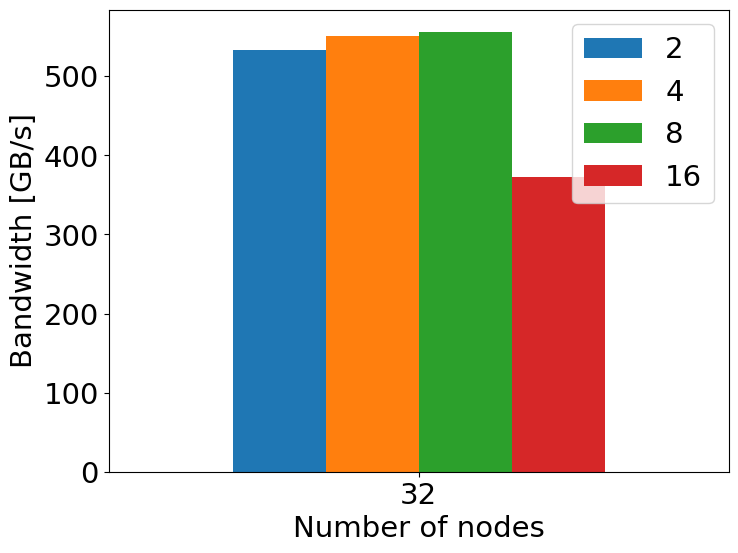

segmentCount,PEANUTS w/ aggread
i64,f64
2,533.735225
4,550.776769
8,556.235944
16,372.069663


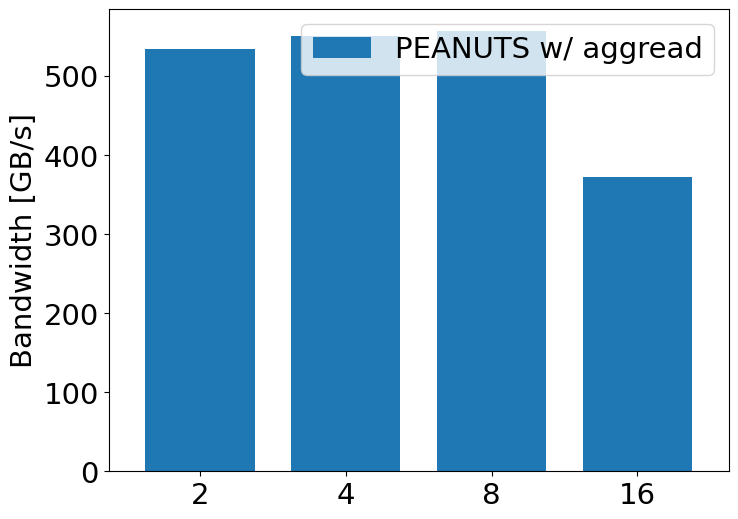

('PEANUTS w/ aggread',)


ComputeError: found multiple elements in the same group, please specify an aggregation function

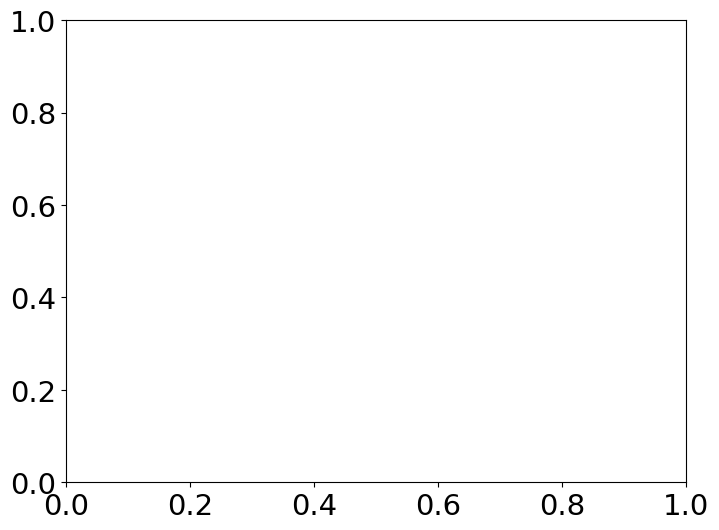

In [79]:
group_by_columns = [
    "storageSystem",
    "aggread",
    "access",
    "nnodes",
    "segmentCount",
]
df = (
    df_src.lazy()
    .filter(
        pl.col("access") == "read",
    )
    .group_by(group_by_columns + ["transferSize"])
    .agg(pl.max("bwGB"))
    .with_columns(
        pl.when((pl.col("storageSystem") != "PEANUTS"))
        .then(pl.col("storageSystem"))
        .when(pl.col("aggread"))
        .then(pl.lit("PEANUTS w/ aggread"))
        .otherwise(pl.lit("PEANUTS w/o aggread"))
        # .alias("legend")
    )
    .sort("nnodes", "segmentCount")
    .collect()
)
# display(df)


for (storageSystem,),df_sub in df.group_by("storageSystem"):
    fig, axes = plt.subplots(ncols=1, figsize=(8, 6), sharey=True)
    fig.patch.set_alpha(1)
    print(storageSystem)
    # display(df_sub)
    (
        df_sub
        .filter(pl.col("segmentCount") > 1)
        .group_by(group_by_columns)
        .agg(pl.max("bwGB"))
        .sort("nnodes", "segmentCount")
        .pivot(values="bwGB", index="nnodes", on="segmentCount")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("nnodes")
        .plot(
            ax=axes,
            kind="bar",
            xlabel="Number of nodes",
            ylabel="Bandwidth [GB/s]",
            rot=0,
            width=0.75,
        )
    )
    plt.show()

fig, axes = plt.subplots(ncols=1, figsize=(8, 6), sharey=True)
fig.patch.set_alpha(1)

(
    df
    .filter(pl.col("segmentCount") > 1)
    # .filter(pl.col("storageSystem") == "PEANUTS")
    # .filter(pl.col("aggread"))
    # .filter(pl.col("transferSize") == 64 * 2**10)
    .group_by(group_by_columns)
    .agg(pl.max("bwGB"))
    # .pipe(lambda df: (display(df), df)[-1])
    # .sort("segmentcount")
    .sort("nnodes", "segmentCount")
    .pivot(values="bwGB", index="segmentCount", on="storageSystem")
    # .select(["nnodes", "PEANUTS w/o aggread", "PEANUTS w/ aggread"])
    # .sort("nnodes")
    .pipe(lambda df: (display(df), df)[-1])
    .to_pandas()
    .set_index("segmentCount")
    # .set_index("nnodes")
    .plot(
        ax=axes,
        kind="bar",
        xlabel="",
        ylabel="Bandwidth [GB/s]",
        rot=0,
        width=0.75,
    )
)
plt.show()


for storageSystem, df_sub in df.group_by("storageSystem"):
    print(storageSystem)
    fig, axes = plt.subplots(ncols=1, figsize=(8, 6), sharey=True)
    fig.patch.set_alpha(1)

    (
        df_sub
        .sort("nnodes", "transferSize")
        .pivot(values="bwGB", index="nnodes", on="transferSize")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("nnodes")
        .plot(
            ax=axes,
            kind="bar",
            xlabel="Number of nodes",
            ylabel="Bandwidth [GB/s]",
            rot=0,
            width=0.75,
        )
    )
    plt.show()

In [7]:
plt.rcParams.update({"font.size": 21})

group_by_columns = [
    "storageSystem",
    "aggread",
    "access",
    "nnodes",
]
df = (
    df_src.lazy()
    .filter(
        pl.col("access") == "read",
    )
    .group_by(group_by_columns + ["transferSize"])
    .agg(pl.max("bwGB"))
    .collect()
)
display(df)


for (access, remote), df_sub in df.group_by(("access", "reorder")):
    print(access, remote)

    ylim=(0, df_sub.select(pl.max("bwGB")).item())

    fig, axes = plt.subplots(ncols=2, figsize=(16, 5), sharey=True)
    fig.patch.set_alpha(1)
    ax0 = (
        df_sub.group_by(group_by_columns)
        .agg(pl.max("bwGB"))
        .pivot(values="bwGB", index="nnodes", columns="storageSystem")
        .rename({"PMEMBB": "PEANUTS"})
        .select(["nnodes", "Lustre", "BeeOND", "CHFS", "UnifyFS", "PEANUTS"])
        .sort("nnodes")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("nnodes")
        .plot(
            ax=axes[0],
            kind="bar",
            xlabel="",
            ylabel="Bandwidth [GB/s]",
            rot=0,
            width=0.75,
        )
    )
    ax0.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
    ax0.grid(which="major", axis="y", alpha=0.8, linestyle="--", linewidth=1)

    ax1 = (
        df_sub.filter(pl.col("storageSystem") == "PMEMBB")
        .with_columns(
            transferSizeH=pl.col("transferSize").map_elements(to_human, pl.String),
        )
        .sort(["nnodes", "transferSize"])
        .pivot(values="bwGB", index="nnodes", columns="transferSizeH")
        .sort("nnodes")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("nnodes")
        .plot(
            ax=axes[1],
            kind="bar",
            xlabel="",
            ylabel="Bandwidth [GB/s]",
            rot=0,
            width=0.75,
        )
    )
    ax1.grid(which="major", axis="y", alpha=0.8, linestyle="--", linewidth=1)
    # ax1.set_ylim(ax0.get_ylim())
    # ax0.set_ylim(ylim)
    # ax1.set_ylim(ylim)

    nnode_list = [int(t.get_text()) for t in ax0.get_xaxis().get_ticklabels()]
    if access == "write":
        for xtick, nnodes in enumerate(nnode_list):
            hline_params = {
                "y": pmem_write_limit(nnodes),
                "xmin": (xtick + 0.01) / len(nnode_list),
                "xmax": (xtick + 0.85) / len(nnode_list),
                "color": "blue",
                "linestyle": "--",
                "linewidth": 2,
            }
            ax0.axhline(**hline_params)
            ax1.axhline(**hline_params)
        ax0.plot([], [], linestyle="--", color="blue", label="PMEM Write Limit", linewidth=2)
        # ax1.plot([], [], linestyle="--", color="blue", label="PMEM Write Limit")
        ax0.set_ylim(0, pmem_write_limit(nnode_list[-1]) * 1.05)
    else:
        for xtick, nnodes in enumerate(nnode_list):
            hline_params = {
                "y": network_limit(nnodes),
                "xmin": (xtick + 0.01) / len(nnode_list),
                "xmax": (xtick + 0.85) / len(nnode_list),
                "color": "green",
                "linestyle": "-.",
                "linewidth": 2,
            }
            ax0.axhline(**hline_params)
            ax1.axhline(**hline_params)
        ax0.set_ylim(0, network_limit(nnode_list[-1]) * 1.05)
        if not remote:
            for xtick, nnodes in enumerate(nnode_list):
                hline_params = {
                    "y": pmem_read_limit(nnodes),
                    "xmin": (xtick + 0.01) / len(nnode_list),
                    "xmax": (xtick + 0.85) / len(nnode_list),
                    "color": "red",
                    "linestyle": ":",
                    "linewidth": 2,
                }
                ax0.axhline(**hline_params)
                ax1.axhline(**hline_params)
            ax0.plot([], [], linestyle=":", color="red", label="PMEM Read Limit", linewidth=2)
            # ax1.plot([], [], linestyle=":", color="red", label="PMEM Read Limit")
            ax0.set_ylim(0, pmem_read_limit(nnode_list[-1]) * 1.05)
        ax0.plot([], [], linestyle="-.", color="green", label="Network Limit", linewidth=2)
        # ax1.plot([], [], linestyle="-.", color="green", label="Network Limit")

    ax1.set_ylim(ax0.get_ylim())
    ax0.legend(title="", fontsize=20)
    ax1.legend(title="", fontsize=18, ncols=2)

    plt.tight_layout()
    fig.subplots_adjust(wspace=0.02)
    plt.show()
    save(fig, f"ior_bw_{access}_{'remote' if remote else 'local'}_wide")

storageSystem,aggread,access,nnodes,transferSize,bwGB
str,bool,str,i64,i64,f64
"""PEANUTS""",false,"""read""",16,2097152,1026.051852
"""PEANUTS""",true,"""read""",16,2097152,1001.708614


ColumnNotFoundError: reorder